In [89]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn

# !pip install gradio
import gradio as gr

In [90]:
print(torch.cuda.is_available())
device = 'cuda'

True


In [91]:
transform = transforms.ToTensor()

training = datasets.MNIST('./data', train=True, download=True, transform=transform)
testing = datasets.MNIST('./data', train=False, download=True, transform=transform)

In [92]:
from torch.utils.data import random_split

train_set, dev_set = random_split(training, [50000, 10000])

In [123]:
training_loader = DataLoader(train_set, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=32)
testing_loader = DataLoader(testing, batch_size=32)

In [94]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, dropout=0.0, batch_norm=True):
        super().__init__()
        self.layers = [input_size] + hidden_layers + [output_size]
        self.network_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.relu = nn.ReLU()
        self.dropout_prob = dropout
        self.dropout = nn.Dropout(self.dropout_prob)

        for i in range(len(self.layers)-1):
            self.network_layers.append(nn.Linear(self.layers[i], self.layers[i+1]))
            if batch_norm == True:
                self.batch_norm_layers.append(nn.BatchNorm1d(self.layers[i+1]))

    def forward(self, x):
        for i in range(len(self.network_layers)-1): # all layers except output
            x = self.network_layers[i](x)
            if self.batch_norm:
                x = self.batch_norm_layers[i](x)
            x = self.relu(x)
            x = self.dropout(x)

        #output
        x = self.network_layers[-1](x)
        return x

In [95]:
net = NeuralNetwork(784, [256], 10, dropout=0.3, batch_norm=True).cuda()
print(net.layers)

[784, 256, 10]


In [96]:
def dataset_accuracy(model, loader):
    model.eval()

    with torch.no_grad():
        correct_predictions = 0
        for X, y in loader:

            X = X.reshape(-1, 784).cuda()
            y = y.cuda()

            output = model(X)
            correct_predictions += torch.sum(torch.max(output, 1)[1] == y).item()

        model.train()
        return correct_predictions / len(loader.dataset)

In [103]:
import torch.optim

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.0008, weight_decay=0.06)

epochs = 20
for epoch in range(epochs):

    epoch_loss = 0
    correct_predictions = 0

    for X, y in training_loader:

        X = X.reshape(-1, 784).cuda()
        y = y.cuda()

        optimizer.zero_grad()
        output = net(X)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        correct_predictions += torch.sum(torch.max(output, dim=1)[1] == y).item()

    loss_score = epoch_loss/len(training_loader)
    training_accuracy = correct_predictions/len(training_loader.dataset)
    dev_accuracy = dataset_accuracy(net, dev_loader)

    print(f"epoch: {epoch+1}  loss = {loss_score}, training accuracy = {training_accuracy}, dev accuracy = {dev_accuracy}")

print('------------------')
print(f'Test set accuracy = {dataset_accuracy(net, testing_loader)}')

epoch: 1  loss = 0.0611350848141376, training accuracy = 0.98128, dev accuracy = 0.9785
epoch: 2  loss = 0.05855127180415853, training accuracy = 0.98286, dev accuracy = 0.9803
epoch: 3  loss = 0.059335470495129425, training accuracy = 0.98244, dev accuracy = 0.9803
epoch: 4  loss = 0.059111130810703225, training accuracy = 0.98262, dev accuracy = 0.9771
epoch: 5  loss = 0.05768978995448592, training accuracy = 0.98278, dev accuracy = 0.9793
epoch: 6  loss = 0.056362999156558374, training accuracy = 0.98398, dev accuracy = 0.9767
epoch: 7  loss = 0.05769794328127507, training accuracy = 0.98318, dev accuracy = 0.9778
epoch: 8  loss = 0.05759546857461886, training accuracy = 0.98348, dev accuracy = 0.9801
epoch: 9  loss = 0.05630730801281029, training accuracy = 0.98314, dev accuracy = 0.9816
epoch: 10  loss = 0.05691786973289693, training accuracy = 0.98302, dev accuracy = 0.9809
epoch: 11  loss = 0.056746381839501335, training accuracy = 0.98274, dev accuracy = 0.979
epoch: 12  loss =

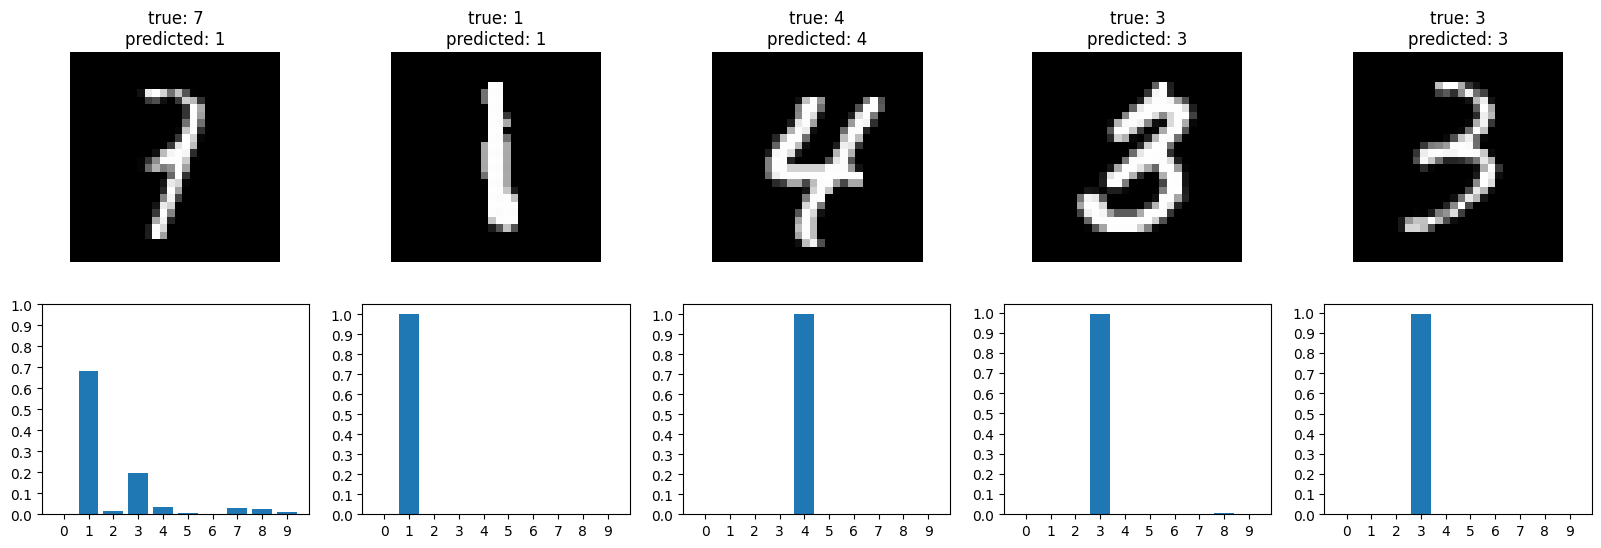

In [98]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_mnist(model, loader, num_images = 5):
    random_choices = np.random.randint(1, 10000, size=num_images)

    images_list = []
    labels_list = []
    predictions_list = []
    probability_distributions_list = []

    model.eval()
    with torch.no_grad():
        for choice in random_choices:
            X, y = loader.dataset[choice]
            X = X.reshape(-1, 784).to('cuda:0')

            logits = model(X)

            _, pred = torch.max(logits, 1)
            predictions_list.append(pred.item())

            probability_distributions_list.append(torch.softmax(logits, 1))

            images_list.append(X.cpu())
            labels_list.append(y)

    fig, axes = plt.subplots(2, num_images, figsize=(20, 6))
    for i in range(num_images):
        axes[0, i].imshow(images_list[i].reshape(28,28), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'true: {labels_list[i]}\npredicted: {predictions_list[i]}')
        axes[1, i].bar(x=np.arange(10), height=probability_distributions_list[i].cpu().numpy().squeeze())
        axes[1, i].set_xticks(np.arange(10))
        axes[1, i].set_yticks(np.linspace(0.0, 1, 11))

    model.train()
    plt.show()
visualize_mnist(net, testing_loader)

In [101]:
import gradio as gr
from PIL import Image

def predict(img):
    # print(img.keys())

    if isinstance(img, dict):
        img = img["composite"]

    if img is None:
        return {str(i): 0.0 for i in range(10)}


    pil = Image.fromarray(img)
    pil = pil.resize((28, 28)).convert('L')
    image = np.array(pil, dtype=np.float32) / 255.0
    image = image.reshape(-1, 28*28)

    image = 1.0 - image


    with torch.no_grad():
        net.eval()

        output = net(torch.from_numpy(image).cuda())
        prediction = torch.softmax(output, 1).cpu().numpy()[0]

        net.train()


    return {str(i): float(prediction[i]) for i in range(10)}

In [112]:
demo = gr.Interface(fn=predict, inputs=gr.Sketchpad(), outputs=gr.Label(num_top_classes=10), live=True)
demo.launch(share=True, debug=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fda9c16f869eb8add6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [124]:
optimizers = {
    'adam': torch.optim.AdamW,
    'rmsprop': torch.optim.RMSprop,
    'sgd': torch.optim.SGD
}

def train(epochs, hidden_layers:list, optimizer, lr, weight_decay, dropout, batch_norm):
    net = NeuralNetwork(784, hidden_layers, 10, dropout=dropout, batch_norm=batch_norm).cuda()

    loss_function = nn.CrossEntropyLoss()
    optimizer = optimizers[optimizer](net.parameters(), lr = lr, weight_decay=weight_decay)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        epoch_loss = 0
        correct_predictions = 0

        for X, y in training_loader:

            X = X.reshape(-1, 784).cuda()
            y = y.cuda()

            optimizer.zero_grad()
            output = net(X)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            correct_predictions += torch.sum(torch.max(output, dim=1)[1] == y).item()

        loss_score = epoch_loss/len(training_loader)
        training_accuracy = correct_predictions/len(training_loader.dataset)
        dev_accuracy = dataset_accuracy(net, dev_loader)

        train_losses.append(loss_score)
        train_accuracies.append(training_accuracy)
        dev_accuracies.append(dev_accuracy)

        print(f"epoch {epoch+1}: training_loss = {loss_score:.9f}, train_accuracy = {training_accuracy:.7f}, dev_accuracy = {dev_accuracy:.7f}")
    print('\n\n')
    return {'training_losses':train_losses, 'training_accuracies':train_accuracies, 'dev_accuracies':dev_accuracies}

In [126]:
history = train(epochs=20, hidden_layers=[256, 128], optimizer='adam', lr=0.0008, weight_decay=0.06, dropout=0.3, batch_norm=True)

epoch 1: training_loss = 0.339812097, train_accuracy = 0.9042400, dev_accuracy = 0.9622000
epoch 2: training_loss = 0.185157885, train_accuracy = 0.9438600, dev_accuracy = 0.9679000
epoch 3: training_loss = 0.151745307, train_accuracy = 0.9536000, dev_accuracy = 0.9741000
epoch 4: training_loss = 0.133485126, train_accuracy = 0.9580600, dev_accuracy = 0.9742000
epoch 5: training_loss = 0.121349489, train_accuracy = 0.9614200, dev_accuracy = 0.9769000
epoch 6: training_loss = 0.111286848, train_accuracy = 0.9663600, dev_accuracy = 0.9770000
epoch 7: training_loss = 0.104479162, train_accuracy = 0.9671600, dev_accuracy = 0.9782000
epoch 8: training_loss = 0.099519314, train_accuracy = 0.9692000, dev_accuracy = 0.9784000
epoch 9: training_loss = 0.094936971, train_accuracy = 0.9703600, dev_accuracy = 0.9777000
epoch 10: training_loss = 0.089599179, train_accuracy = 0.9717000, dev_accuracy = 0.9795000
epoch 11: training_loss = 0.089108936, train_accuracy = 0.9719000, dev_accuracy = 0.97930

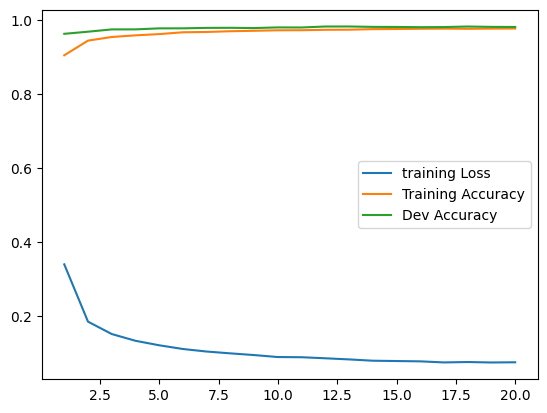

In [129]:
plt.plot(np.arange(len(history['training_losses'])) + 1, history['training_losses'], label='training Loss')
plt.plot(np.arange(len(history['training_accuracies'])) + 1, history['training_accuracies'], label='Training Accuracy')
plt.plot(np.arange(len(history['dev_accuracies'])) + 1, history['dev_accuracies'], label='Dev Accuracy')
plt.legend()
plt.show()